Project: /mediapipe/_project.yaml
Book: /mediapipe/_book.yaml

<link rel="stylesheet" href="/mediapipe/site.css">

# Hand gesture recognition model maker

<table align="left" class="buttons">
  <td>
    <a href="https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/customization/gesture_recognizer.ipynb" target="_blank">
      <img src="https://developers.google.com/static/mediapipe/solutions/customization/colab-logo-32px_1920.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
</table>

In [ ]:
#@title License information
# Copyright 2023 The MediaPipe Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
#
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


The MediaPipe Model Maker package is a low-code solution for customizing on-device machine learning (ML) Models.

This notebook shows the end-to-end process of customizing a gesture recognizer model for recognizing some common hand gestures in the [HaGRID](https://www.kaggle.com/datasets/innominate817/hagrid-sample-30k-384p) dataset.

## Prerequisites

Import the required libraries.

In [1]:
import os
import tensorflow as tf
assert tf.__version__.startswith('2')

import constants as const
import helper

from mediapipe_model_maker import gesture_recognizer

import matplotlib.pyplot as plt


2024-05-07 10:40:10.281342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/typ/miniconda3/envs/env_mediapipe_tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Simple End-to-End Example

This end-to-end example uses Model Maker to customize a model for on-device gesture recognition.

### Get the dataset

The dataset for gesture recognition in model maker requires the following format: `<dataset_path>/<label_name>/<img_name>.*`. In addition, one of the label names (`label_names`) must be `none`. The `none` label represents any gesture that isn't classified as one of the other gestures.

In [2]:
dataset_path = "handtalk-dataset"


Verify the rock paper scissors dataset by printing the labels. There should be 4 gesture labels, with one of them being the `none` gesture.

In [3]:
print(dataset_path)
labels = []
for i in os.listdir(dataset_path):
  if os.path.isdir(os.path.join(dataset_path, i)):
    labels.append(i)
print(labels)


handtalk-dataset
['51', '20', '18', '9', '11', '7', '6', '1', '10', '19', '8', '21', '44', 'none', '46', '4', '15', '3', '49', '47', '13', '5', '14', '22']


To better understand the dataset, plot a couple of example images for each gesture.

/var/folders/c1/1z77vdp56vv84vg3fl8ywh980000gp/T/ipykernel_31320/3802573452.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))


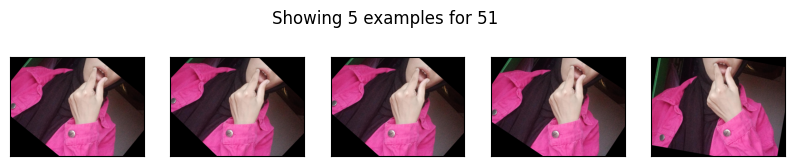

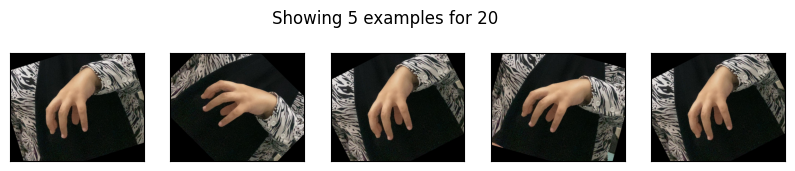

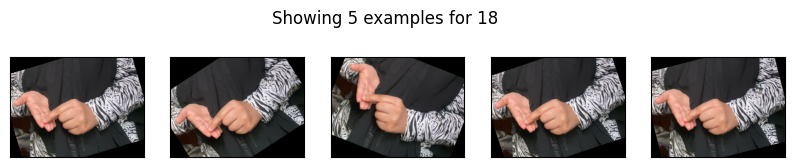

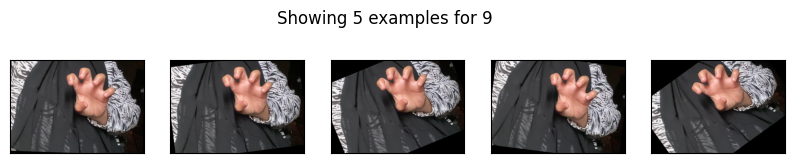

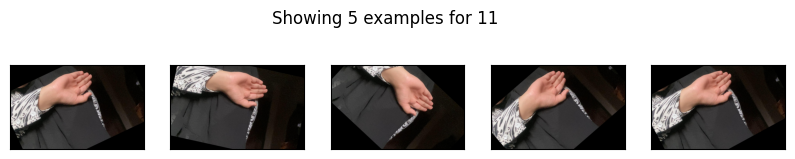

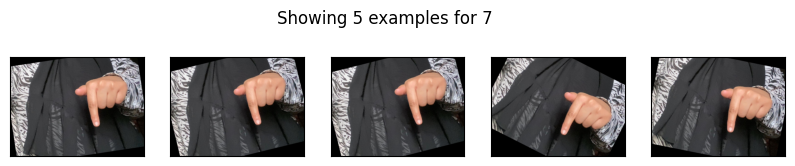

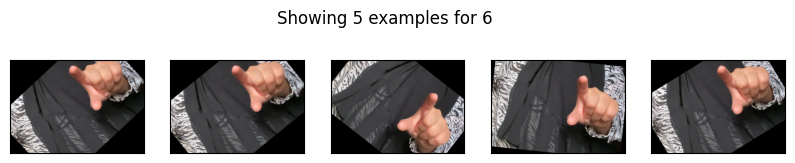

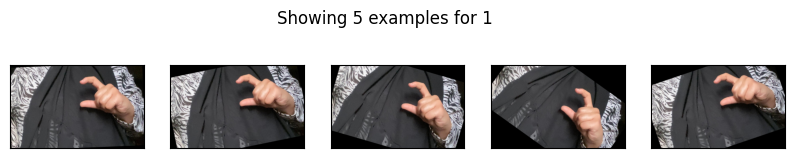

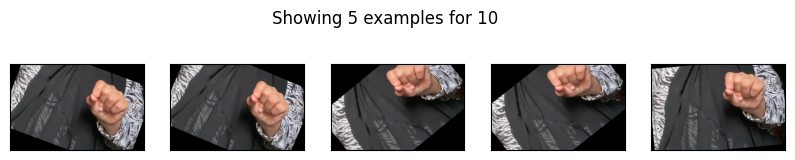

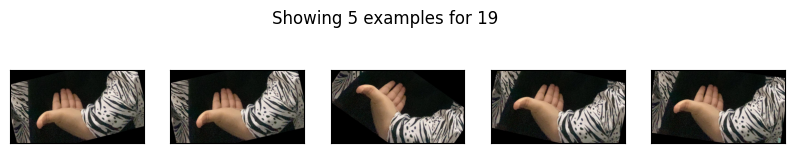

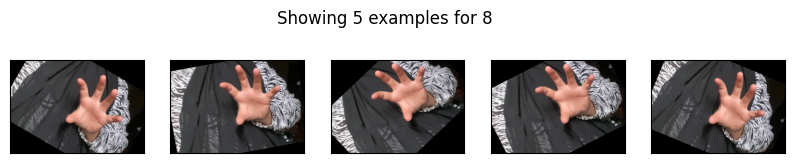

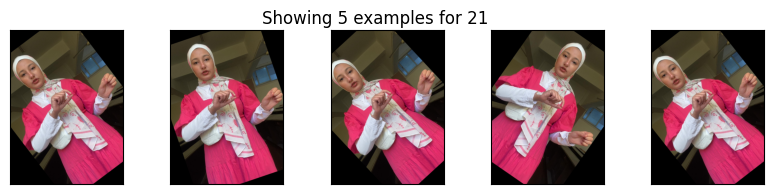

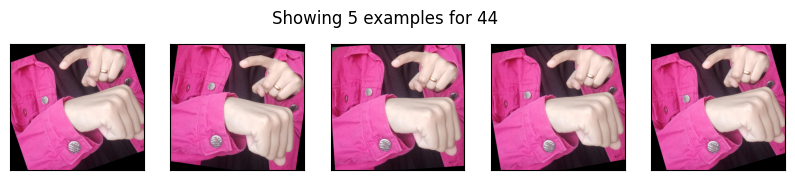

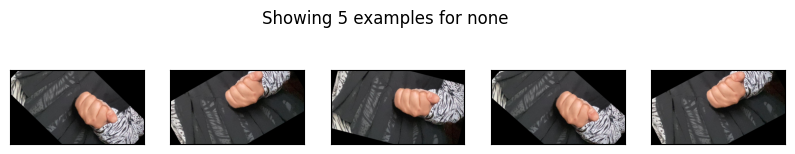

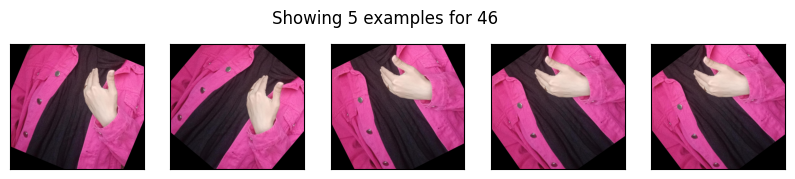

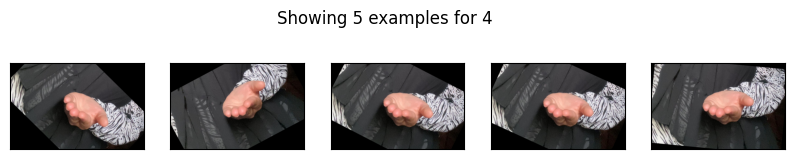

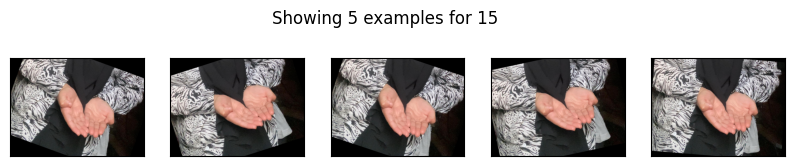

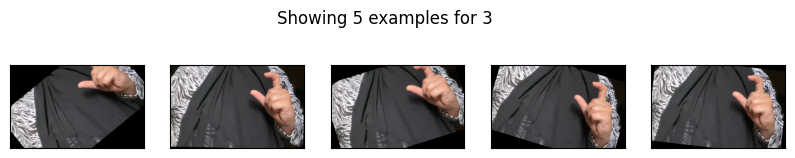

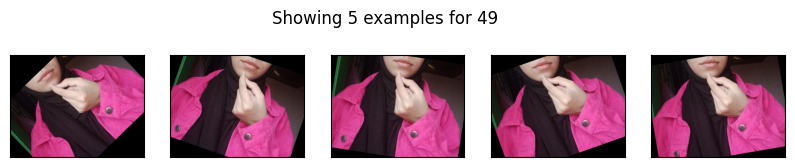

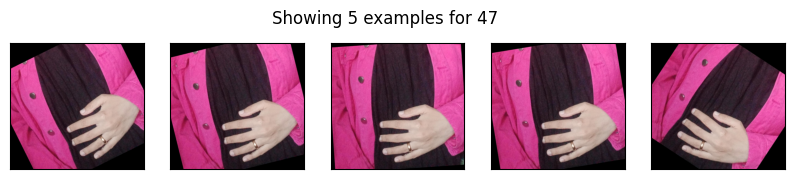

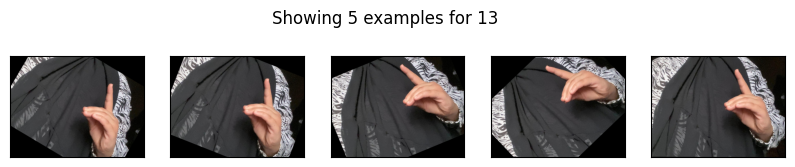

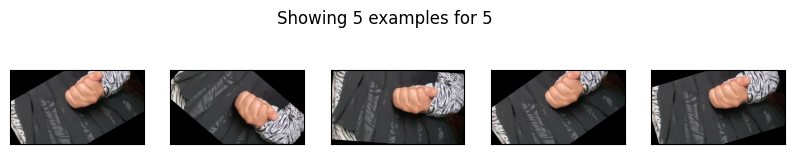

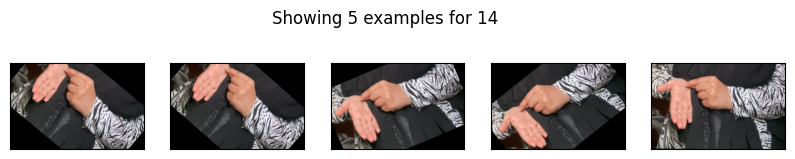

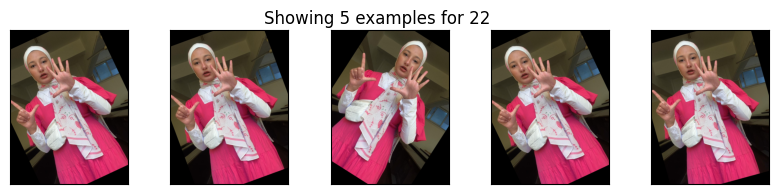

In [4]:
NUM_EXAMPLES = 5

for label in labels:
  label_dir = os.path.join(dataset_path, label)
  example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
  for i in range(NUM_EXAMPLES):
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

plt.show()


### Run the example
The workflow consists of 4 steps which have been separated into their own code blocks.

**Load the dataset**

Load the dataset located at `dataset_path` by using the `Dataset.from_folder` method. When loading the dataset, run the pre-packaged hand detection model from MediaPipe Hands to detect the hand landmarks from the images. Any images without detected hands are ommitted from the dataset. The resulting dataset will contain the extracted hand landmark positions from each image, rather than images themselves.

The `HandDataPreprocessingParams` class contains two configurable options for the data loading process:
* `shuffle`: A boolean controlling whether to shuffle the dataset. Defaults to true.
* `min_detection_confidence`: A float between 0 and 1 controlling the confidence threshold for hand detection.

Split the dataset: 80% for training, 10% for validation, and 10% for testing.

In [5]:
data = gesture_recognizer.Dataset.from_folder(
    dirname=dataset_path,
    hparams=gesture_recognizer.HandDataPreprocessingParams()
)
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)


INFO:tensorflow:Loading image /Users/typ/Development/HandTalk-AI/handtalk-dataset/1/1_aug_33.jpg
INFO:tensorflow:Loading image /Users/typ/Development/HandTalk-AI/handtalk-dataset/51/51_aug_26.jpg
INFO:tensorflow:Loading image /Users/typ/Development/HandTalk-AI/handtalk-dataset/46/46_aug_96.jpg
INFO:tensorflow:Loading image /Users/typ/Development/HandTalk-AI/handtalk-dataset/4/4_aug_69.jpg
INFO:tensorflow:Loading image /Users/typ/Development/HandTalk-AI/handtalk-dataset/10/10_aug_100.jpg
INFO:tensorflow:Loading image /Users/typ/Development/HandTalk-AI/handtalk-dataset/14/14_aug_60.jpg
INFO:tensorflow:Loading image /Users/typ/Development/HandTalk-AI/handtalk-dataset/7/7_aug_52.jpg
INFO:tensorflow:Loading image /Users/typ/Development/HandTalk-AI/handtalk-dataset/14/14_aug_49.jpg
INFO:tensorflow:Loading image /Users/typ/Development/HandTalk-AI/handtalk-dataset/47/47_aug_48.jpg
INFO:tensorflow:Loading image /Users/typ/Development/HandTalk-AI/handtalk-dataset/10/10_aug_90.jpg
INFO:tensorflow

INFO:tensorflow:Load valid hands with size: 2291, num_label: 24, labels: none,1,10,11,13,14,15,18,19,20,21,22,3,4,44,46,47,49,5,51,6,7,8,9.


**Train the model**

Train the custom gesture recognizer by using the create method and passing in the training data, validation data, model options, and hyperparameters. For more information on model options and hyperparameters, see the [Hyperparameters](#hyperparameters) section below.

In [8]:
hparams = gesture_recognizer.HParams(learning_rate=0.003, export_dir="exported_model", batch_size=25, shuffle=True)
model_options = gesture_recognizer.ModelOptions(dropout_rate=0.2)
options = gesture_recognizer.GestureRecognizerOptions(model_options=model_options, hparams=hparams)
model = gesture_recognizer.GestureRecognizer.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options
)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hand_embedding (InputLayer  [(None, 128)]             0         
 )                                                               
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 re_lu_2 (ReLU)              (None, 128)               0         
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 custom_gesture_recognizer_  (None, 24)                3096      
 out (Dense)                                                     
                                                           

INFO:tensorflow:Training the gesture recognizer model...


Resuming from exported_model/epoch_models/model-0010
Epoch 1/10
73/73 [==============================] - 2s 14ms/step - loss: 0.0680 - categorical_accuracy: 0.9364 - val_loss: 0.0189 - val_categorical_accuracy: 0.9738 - lr: 0.0030
Epoch 2/10
73/73 [==============================] - 1s 11ms/step - loss: 0.0656 - categorical_accuracy: 0.9282 - val_loss: 0.0201 - val_categorical_accuracy: 0.9738 - lr: 0.0030
Epoch 3/10
73/73 [==============================] - 1s 12ms/step - loss: 0.0685 - categorical_accuracy: 0.9315 - val_loss: 0.0173 - val_categorical_accuracy: 0.9782 - lr: 0.0029
Epoch 4/10
73/73 [==============================] - 1s 13ms/step - loss: 0.0581 - categorical_accuracy: 0.9271 - val_loss: 0.0181 - val_categorical_accuracy: 0.9738 - lr: 0.0029
Epoch 5/10
73/73 [==============================] - 1s 11ms/step - loss: 0.0614 - categorical_accuracy: 0.9315 - val_loss: 0.0151 - val_categorical_accuracy: 0.9782 - lr: 0.0029
Epoch 6/10
73/73 [==============================] - 1s 12

**Evaluate the model performance**

After training the model, evaluate it on a test dataset and print the loss and accuracy metrics.

In [9]:
loss, acc = model.evaluate(test_data, batch_size=1)
print(f"Test loss:{loss}, Test accuracy:{acc}")


230/230 [==============================] - 1s 1ms/step - loss: 0.0266 - categorical_accuracy: 0.9478
Test loss:0.026586653664708138, Test accuracy:0.947826087474823


**Export to Tensorflow Lite Model**

After creating the model, convert and export it to a Tensorflow Lite model format for later use on an on-device application. The export also includes model metadata, which includes the label file.

In [10]:
model.export_model()


INFO:tensorflow:Assets written to: /var/folders/c1/1z77vdp56vv84vg3fl8ywh980000gp/T/tmpfq0e0azx/saved_model/assets


INFO:tensorflow:Assets written to: /var/folders/c1/1z77vdp56vv84vg3fl8ywh980000gp/T/tmpfq0e0azx/saved_model/assets
2024-05-07 10:47:51.921952: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-07 10:47:51.922253: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-07 10:47:51.925502: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/c1/1z77vdp56vv84vg3fl8ywh980000gp/T/tmpfq0e0azx/saved_model
2024-05-07 10:47:51.926841: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-07 10:47:51.926859: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/c1/1z77vdp56vv84vg3fl8ywh980000gp/T/tmpfq0e0azx/saved_model
2024-05-07 10:47:51.932639: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-05-07 10:47:51.9338

## Run the model on-device

To use the TFLite model for on-device usage through MediaPipe Tasks, refer to the Gesture Recognizer [overview page](https://developers.google.com/mediapipe/solutions/vision/gesture_recognizer).

## Hyperparameters {:#hyperparameters}


You can further customize the model using the `GestureRecognizerOptions` class, which has two optional parameters for `ModelOptions` and `HParams`. Use the `ModelOptions` class to customize parameters related to the model itself, and the `HParams` class to customize other parameters related to training and saving the model.

`ModelOptions` has one customizable parameter that affects accuracy:
* `dropout_rate`: The fraction of the input units to drop. Used in dropout layer. Defaults to 0.05.
* `layer_widths`: A list of hidden layer widths for the gesture model. Each element in the list will create a new hidden layer with the specified width. The hidden layers are separated with BatchNorm, Dropout, and ReLU. Defaults to an empty list(no hidden layers).

`HParams` has the following list of customizable parameters which affect model accuracy:
* `learning_rate`: The learning rate to use for gradient descent training. Defaults to 0.001.
* `batch_size`: Batch size for training. Defaults to 2.
* `epochs`: Number of training iterations over the dataset. Defaults to 10.
* `steps_per_epoch`: An optional integer that indicates the number of training steps per epoch. If not set, the training pipeline calculates the default steps per epoch as the training dataset size divided by batch size.
* `shuffle`: True if the dataset is shuffled before training. Defaults to False.
* `lr_decay`: Learning rate decay to use for gradient descent training. Defaults to 0.99.
* `gamma`: Gamma parameter for focal loss. Defaults to 2

Additional `HParams` parameter that does not affect model accuracy:
* `export_dir`: The location of the model checkpoint files and exported model files.

For example, the following trains a new model with the dropout_rate of 0.2 and learning rate of 0.003.

In [ ]:
hparams = gesture_recognizer.HParams(learning_rate=0.003, export_dir="exported_model_2", batch_size=10, shuffle=True)
model_options = gesture_recognizer.ModelOptions(dropout_rate=0.2)
options = gesture_recognizer.GestureRecognizerOptions(model_options=model_options, hparams=hparams)
model_2 = gesture_recognizer.GestureRecognizer.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options
)


Evaluate the newly trained model.

In [ ]:
loss, accuracy = model_2.evaluate(test_data)
model_2.export_model()
print(f"Test loss:{loss}, Test accuracy:{accuracy}")
